In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv('train.csv', encoding='cp949')
test = df[df["배추_거래량(kg)"] != 0 ]
#test = df[df["요일"] == "화요일"] #  화요일에 대한 정보만 나오게 됨
test = test[["배추_거래량(kg)", "배추_가격(원/kg)"]] # 화요일에 대한 배추거래량
plt.figure(figsize=(9, 6))
plt.plot(test["배추_가격(원/kg)"], label = '배추_가격(원/kg)')
#window data set
print("-------------------MinMaxScaler---------------------")
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['배추_거래량(kg)']
scaled = scaler.fit_transform(test[scale_cols]) 
test["Volume_scaled"] = scaled
test.head()

def windowed_dataset(series, window_size, batch_size, shuffle, asp):
    #series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + asp, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + asp))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-asp], w[-1][0])) # two, four
    return ds.batch(batch_size).prefetch(1)

from sklearn.model_selection import train_test_split
test = test[['Close_scaled','Volume_scaled']]
train, test = train_test_split(test, test_size=0.3, random_state=0, shuffle=False)
valid, test = train_test_split(test, test_size=0.66, random_state=0, shuffle=False)


print("----------------train, test 분리 후 shape 출력-------------------")
print("train : ", train.shape,"validation :", valid.shape, "test : ", test.shape)

import tensorflow as tf

WINDOW_SIZE= 50
BATCH_SIZE= 100 # 데이터는 총 50개씩 랜덤으로 뽑음

train_data = windowed_dataset(train, WINDOW_SIZE, BATCH_SIZE, False,8) 
valid_data = windowed_dataset(valid, WINDOW_SIZE, BATCH_SIZE, False,8) 
test_data = windowed_dataset(test, WINDOW_SIZE, BATCH_SIZE, False,8)


class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    hidden_with_time_axis = tf.expand_dims(query, 1)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1) # 행 단위로 전부 더한다.
    return context_vector, attention_weights

from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout, Conv1D
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os
import numpy as np

sequence_input = Input(shape=(WINDOW_SIZE,2))
cnn1d = Conv1D(32, 6, padding='valid')(sequence_input)
lstm = Bidirectional(LSTM(128, dropout=0.5, return_sequences = True))(cnn1d)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.2, return_sequences=True, return_state=True))(lstm)

state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

attention = BahdanauAttention(128) # unit의 수
context_vector, attention_weights = attention(lstm, state_h) # lstm에 존재하는 애들로 비교, state_h는 제일 마지막 입력에 대한 입력
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.2)(dense1)
output = Dense(1)(dense1)
model = Model(inputs=sequence_input, outputs=output) 
# 함수형 API를 사용한 경우 INPUT과 OUTPUT을 명확하게 설정해야줘야 한다.

model.summary()
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

checkpoint = ModelCheckpoint('ckeckpointer1.ckpt',  # 가장 val_loss가 적게 떨어졌을 때의 모델 체크|
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)


history = model.fit(train_data, epochs = 400, validation_data=(valid_data), verbose=1, callbacks = [checkpoint])
model.load_weights('ckeckpointer1.ckpt')
pred = model.predict(test_data)

import numpy as np
plt.figure(figsize=(12, 9))
test = test["Close_scaled"]
plt.plot(np.array(test[50:]), label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()



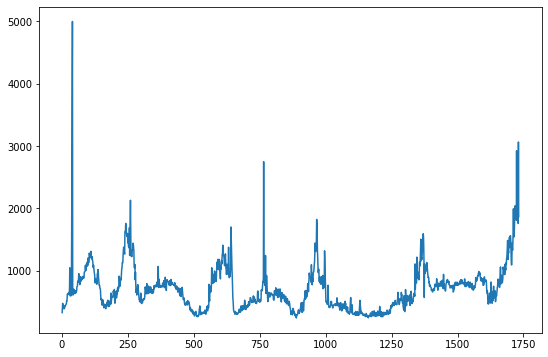

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(test["배추_가격(원/kg)"], label = '배추_가격(원/kg)')

In [ ]:
#window data set
print("-------------------MinMaxScaler---------------------")
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['배추_거래량(kg)']
scaled = scaler.fit_transform(test[scale_cols]) 
test["Volume_scaled"] = scaled
test.head()

-------------------MinMaxScaler---------------------


,배추_거래량(kg),배추_가격(원/kg),Volume_scaled
1,80860.0,329,0.015514
3,1422742.5,478,0.273064
4,1167241.0,442,0.224025
5,1045507.5,442,0.200661
6,1039925.0,448,0.199589


In [ ]:
scale_cols = ['배추_가격(원/kg)']
scaled = scaler.fit_transform(test[scale_cols]) 
test["Close_scaled"] = scaled
test.head()

,배추_거래량(kg),배추_가격(원/kg),Volume_scaled,Close_scaled
1,80860.0,329,0.015514,0.018079
3,1422742.5,478,0.273064,0.049401
4,1167241.0,442,0.224025,0.041833
5,1045507.5,442,0.200661,0.041833
6,1039925.0,448,0.199589,0.043094


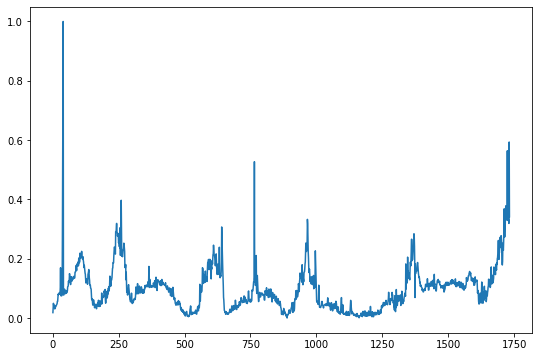

In [ ]:
plt.figure(figsize=(9, 6))
plt.plot(test["Close_scaled"], label = '배추_가격(원/kg)')

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle, asp):
    #series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + asp, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + asp))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-asp], w[-1][0])) # two, four
    return ds.batch(batch_size).prefetch(1)

In [ ]:
from sklearn.model_selection import train_test_split
test = test[['Close_scaled','Volume_scaled']]
train, test = train_test_split(test, test_size=0.3, random_state=0, shuffle=False)
valid, test = train_test_split(test, test_size=0.66, random_state=0, shuffle=False)

In [ ]:
print("----------------train, test 분리 후 shape 출력-------------------")
print("train : ", train.shape,"validation :", valid.shape, "test : ", test.shape)

----------------train, test 분리 후 shape 출력-------------------
train :  (1036, 2) validation : (150, 2) test :  (294, 2)


In [ ]:
import tensorflow as tf

WINDOW_SIZE= 50
BATCH_SIZE= 100 # 데이터는 총 50개씩 랜덤으로 뽑음

train_data = windowed_dataset(train, WINDOW_SIZE, BATCH_SIZE, False,7) 
valid_data = windowed_dataset(valid, WINDOW_SIZE, BATCH_SIZE, False,7) 
test_data = windowed_dataset(test, WINDOW_SIZE, BATCH_SIZE, False,7)

In [ ]:
print("----------------- y value trans test -----------------")

for data in train_data.take(1): # month 데이터로 테스트 구분 # 확인 완료
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

----------------- y value trans test -----------------
데이터셋(X) 구성(batch_size, window_size, feature갯수): (100, 50, 2)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (100,)


In [ ]:
import tensorflow as tf

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1) # 행 단위로 전부 더한다.
    return context_vector, attention_weights

from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout, Conv1D
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os
import numpy as np

sequence_input = Input(shape=(WINDOW_SIZE,2))
cnn1d = Conv1D(32, 6, padding='valid')(sequence_input)
lstm = Bidirectional(LSTM(128, dropout=0.5, return_sequences = True))(cnn1d)
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.2, return_sequences=True, return_state=True))(lstm)

state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

attention = BahdanauAttention(128) # unit의 수
context_vector, attention_weights = attention(lstm, state_h) # lstm에 존재하는 애들로 비교, state_h는 제일 마지막 입력에 대한 입력
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.2)(dense1)
output = Dense(1)(dense1)
model = Model(inputs=sequence_input, outputs=output) 
# 함수형 API를 사용한 경우 INPUT과 OUTPUT을 명확하게 설정해야줘야 한다.

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 50, 2)]      0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 45, 32)       416         input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 45, 256)      164864      conv1d_2[0][0]                   
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) [(None, 45, 128), (N 164352      bidirectional_4[0][0]            
____________________________________________________________________________________________

In [ ]:
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

checkpoint = ModelCheckpoint('ckeckpointer1.ckpt',  # 가장 val_loss가 적게 떨어졌을 때의 모델 체크|
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
history = model.fit(train_data, epochs = 400, validation_data=(valid_data), verbose=1, callbacks = [checkpoint])

Epoch 1/400
10/10 [==============================] - 9s 252ms/step - loss: 0.0035 - mse: 0.0069 - val_loss: 0.0051 - val_mse: 0.0102

Epoch 00001: val_loss improved from inf to 0.00508, saving model to ckeckpointer1.ckpt
Epoch 2/400
10/10 [==============================] - 1s 76ms/step - loss: 0.0029 - mse: 0.0059 - val_loss: 0.0024 - val_mse: 0.0049

Epoch 00002: val_loss improved from 0.00508 to 0.00244, saving model to ckeckpointer1.ckpt
Epoch 3/400
10/10 [==============================] - 1s 77ms/step - loss: 0.0022 - mse: 0.0044 - val_loss: 0.0023 - val_mse: 0.0046

Epoch 00003: val_loss improved from 0.00244 to 0.00229, saving model to ckeckpointer1.ckpt
Epoch 4/400
10/10 [==============================] - 1s 76ms/step - loss: 0.0019 - mse: 0.0037 - val_loss: 0.0029 - val_mse: 0.0058

Epoch 00004: val_loss did not improve from 0.00229
Epoch 5/400
10/10 [==============================] - 1s 76ms/step - loss: 0.0020 - mse: 0.0040 - val_loss: 0.0023 - val_mse: 0.0047

Epoch 00005: v

In [ ]:
model.load_weights('ckeckpointer1.ckpt')
pred = model.predict(test_data)

In [ ]:
pred.shape

(238, 1)

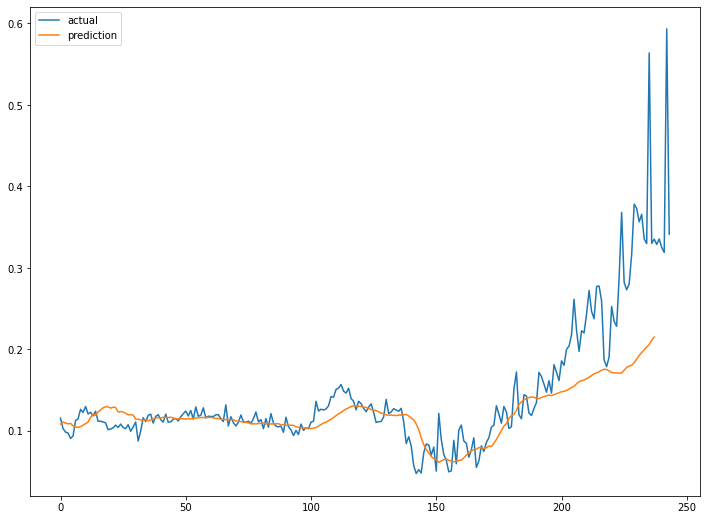

In [ ]:
import numpy as np
plt.figure(figsize=(12, 9))
test = test["Close_scaled"]
plt.plot(np.array(test[50:]), label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()